In [18]:
# ------------- import external libs  ----------------- #
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
from memory_profiler import profile
import psutil
import os
import tracemalloc
import torch
from IPython.display import Image, display
from scipy.stats import entropy
from PIL import Image as PILImage

# ------------- import user libs  --------------------- #
# import bay_matting_fun as bm
import bay_matting_fun_optimized as bm
import bay_matting_un_fun as un


In [19]:
# ------------- file path define  --------------------- #

# low
# # general
#image_path = 'Dataset/input_training_lowres/GT01.png'
# # evaluation
alpha_map_ground_truth_path = 'Dataset/gt_training_lowres/GT01.png'

# high
# general
#image_path = 'Dataset/input_training_highres/GT03.png'
# evaluation
#alpha_map_ground_truth_path = 'Dataset/gt_training_highres/GT03.png'

# custom img
image_path = '/Users/tanqiwen/Desktop/CM_Matting/003Python Project/python_prj/Dataset/input_training_lowres/GT01.png'
trimap_path = '/Users/tanqiwen/Desktop/CM_Matting/003Python Project/python_prj/Dataset/trimap_training_lowres/GT01.png'
# image_path = 'tan.jpg'

# constant
# trimap_path = 'alpha_map_tan.png' # constant don't modify
alpha_map_path = 'AlphaMap_tan.png'
saved_alpha_map_path = 'alpha_map_tan.png'

In [20]:
import math
def calculate_image_properties(image_path):
    """
    Calculate and return the pixel count, entropy, and grayscale levels of an image.

    Parameters:
    - image_path: Path to the image file.

    Returns:
    A tuple containing the pixel count, entropy, and number of unique grayscale levels.
    """
    # Load the image
    img = PILImage.open(image_path)

    # Calculate pixel count
    pixel_count = img.width * img.height

    # Convert image to grayscale
    gray_img = img.convert('L')

    # Calculate grayscale levels
    gray_levels = len(np.unique(gray_img))

    # Calculate entropy
    histogram = gray_img.histogram()
    prob_dist = histogram / np.sum(histogram)
    img_entropy = entropy(prob_dist, base=2)

    return pixel_count, img_entropy, gray_levels

pixel_count, img_entropy, gray_levels = calculate_image_properties(image_path)

print(f"Pixel Count: {pixel_count}")
print(f"Entropy: {img_entropy:.2f}")
print(f"Grayscale Levels: {gray_levels}")

iteration=math.ceil((pixel_count*img_entropy*100*gray_levels)**(1/4)/50)
print(f"Iteration: {iteration}")

Pixel Count: 397600
Entropy: 7.03
Grayscale Levels: 217
Iteration: 10


12.0
254.0


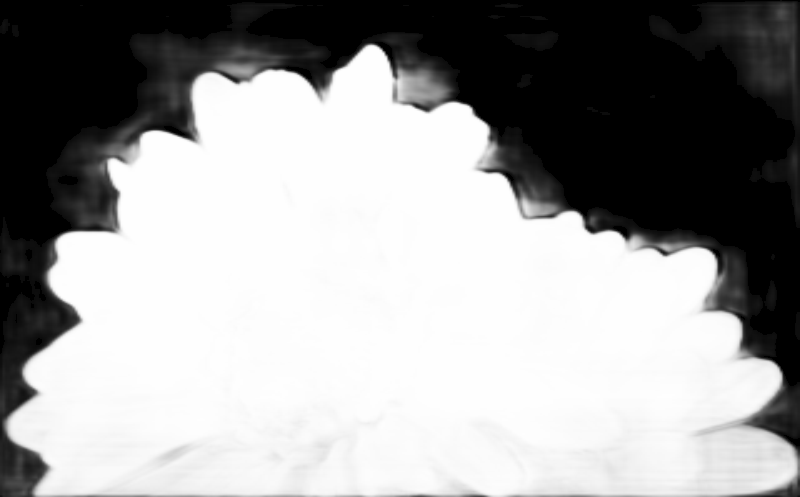

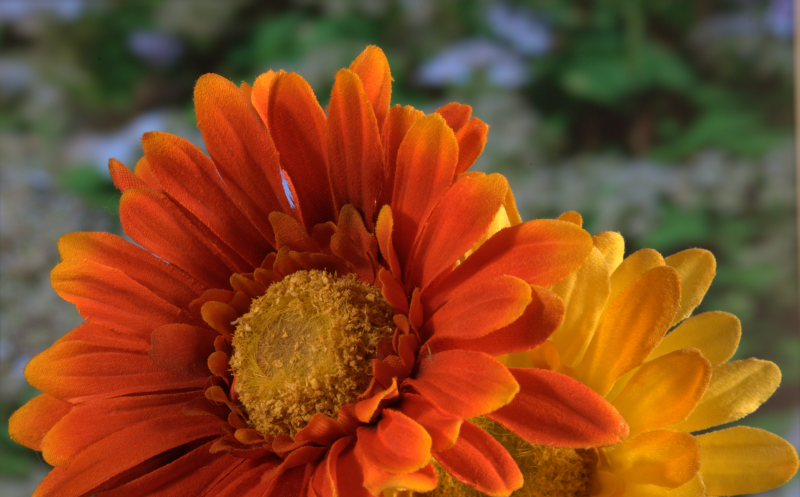

In [21]:
def dynamic_threshold_alpha_map(alpha_map, lower_percentile=25, upper_percentile=75):
    """
    Dynamically adjusts the threshold values for converting an alpha map to a trimap
    based on specified percentiles.

    Parameters:
    - alpha_map: Numpy array representing the alpha map.
    - lower_percentile: The lower percentile for setting pixels to black. Defaults to 1.
    - upper_percentile: The upper percentile for setting pixels to white. Defaults to 99.

    Returns:
    - A numpy array representing the adjusted alpha map.
    """
    # Calculate dynamic thresholds based on the percentiles
    lower_threshold = np.percentile(alpha_map, lower_percentile)
    upper_threshold = np.percentile(alpha_map, upper_percentile)
    print(lower_threshold)
    print(upper_threshold)
    # Apply thresholds
    alpha_map = np.where(alpha_map < lower_threshold, 0, alpha_map)
    alpha_map = np.where(alpha_map > upper_threshold, 255, alpha_map)

    return alpha_map

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate alpha map using a hypothetical function
alpha_map = un.inference_and_get_alphamap(image_path, device)

# un.save_alpha_map(alpha_map, saved_alpha_map_path)  
# display(Image(filename=saved_alpha_map_path))

# Dynamically adjust the alpha map
alpha_map_adjusted = dynamic_threshold_alpha_map(alpha_map)

# Save the adjusted alpha map and display it
un.save_alpha_map(alpha_map_adjusted, saved_alpha_map_path)  

# Displaying the saved alpha map and original image for comparison
display(Image(filename=saved_alpha_map_path))
display(Image(filename=image_path))

(497, 800)


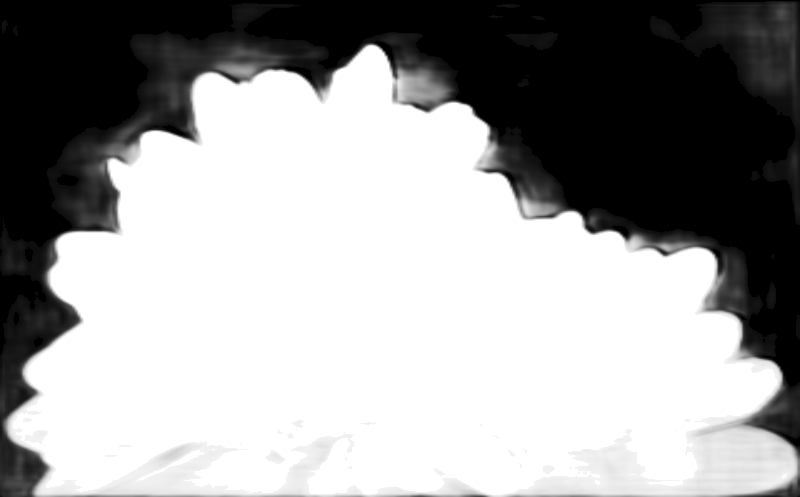

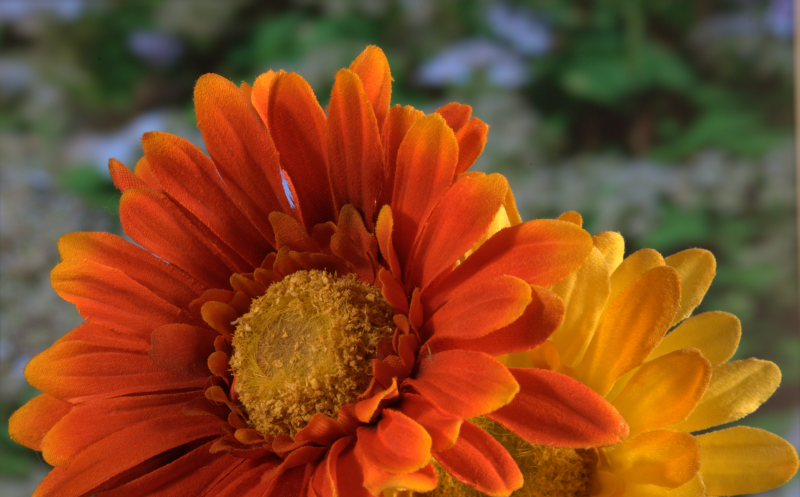

In [22]:
# generate trimap with nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alpha_map = un.inference_and_get_alphamap(image_path, device)

print(alpha_map.shape)

alpha_map = np.where(alpha_map < 255*0.05, 0, alpha_map)
alpha_map = np.where(alpha_map > 255*0.95, 255, alpha_map)

un.save_alpha_map(alpha_map, saved_alpha_map_path)  
display(Image(filename=saved_alpha_map_path))
display(Image(filename=image_path))

38573it [00:39, 970.38it/s] 

Total memory usage: 438202 bytes
Elapsed time: 48.00604796409607 seconds
Alpha Map saved to: AlphaMap_tan.png


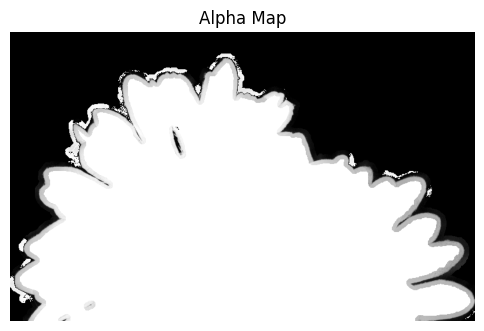

In [23]:
# ------------- complexity estimation begin ----------- #
tracemalloc.start()
start_time = time.time()
# ------------- estimate function begin --------------- #
AlphaMap = bm.bayesian_matting(image_path, trimap_path, oriVar=8, Iteration=iteration)
# ------------- estimate function  end  --------------- #
# calculate memory consumption
snapshot = tracemalloc.take_snapshot()
stats = snapshot.statistics('lineno')
total_memory = sum(stat.size for stat in stats)
print(f"Total memory usage: {total_memory} bytes")
tracemalloc.stop()
# calculate time consumption
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")
# ------------- complexity estimation end ------------- #


# save alpha map output

cv2.imwrite(alpha_map_path, AlphaMap)
print("Alpha Map saved to:", alpha_map_path)

# display alpha map
plt.figure(figsize=(6, 6))
plt.imshow(AlphaMap, cmap='gray')
plt.title("Alpha Map")
plt.axis('off')
plt.show()

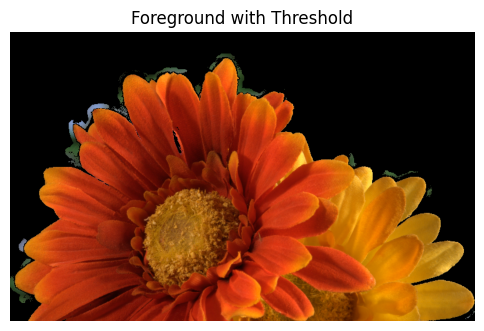

Total memory usage: 1893930 bytes
Elapsed time: 0.1367650032043457 seconds


In [24]:
# ------------- complexity estimation begin ----------- #
tracemalloc.start()
start_time = time.time()
# ------------- estimate function begin --------------- #
bm.show_foreground_with_threshold(image_path, alpha_map_path, threshold=0.5)
# ------------- estimate function  end  --------------- #
# calculate memory consumption
snapshot = tracemalloc.take_snapshot()
stats = snapshot.statistics('lineno')
total_memory = sum(stat.size for stat in stats)
print(f"Total memory usage: {total_memory} bytes")
tracemalloc.stop()
# calculate time consumption
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")
# ------------- complexity estimation end ------------- #

In [25]:
# accuracy estimation
# MSE estimation

# Calculate MSE
mse_value = bm.calculate_alpha_mse(alpha_map_path, alpha_map_ground_truth_path)
print("Mean Squared Error (MSE):", mse_value)


Mean Squared Error (MSE): 0.013118639


In [26]:
# PSNR estimation

# Calculate PSNR
psnr_value = bm.calculate_psnr(alpha_map_path, alpha_map_ground_truth_path)
print("PSNR:", psnr_value)

PSNR: 18.82111230083333
